# Happiness and GDP data: Clustering and predicting GDP by clusters

# Imports 

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import datasets, preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn import preprocessing as prep


from bi_functions_tobias import *

# Loading data frame from file

In [5]:
file_name = 'dataframes.h5'
key = "happiness_df"

df = pd.read_hdf(file_name, key)

# 1) Exploration of data

### 1.1) Getting an overview

In [8]:
df.head()

,Country,Year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.723590,7.350416,0.450662,50.500000,0.718114,0.167652,0.881686,0.414297,0.258195
1,Afghanistan,2009,4.401778,7.508646,0.552308,50.799999,0.678896,0.190809,0.850035,0.481421,0.237092
2,Afghanistan,2010,4.758381,7.613900,0.539075,51.099998,0.600127,0.121316,0.706766,0.516907,0.275324
3,Afghanistan,2011,3.831719,7.581259,0.521104,51.400002,0.495901,0.163571,0.731109,0.479835,0.267175
4,Afghanistan,2012,3.782938,7.660506,0.520637,51.700001,0.530935,0.237588,0.775620,0.613513,0.267919


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1958 entries, 0 to 2198
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country                           1958 non-null   object 
 1   Year                              1958 non-null   int64  
 2   Life Ladder                       1958 non-null   float64
 3   Log GDP per capita                1958 non-null   float64
 4   Social support                    1958 non-null   float64
 5   Healthy life expectancy at birth  1958 non-null   float64
 6   Freedom to make life choices      1958 non-null   float64
 7   Generosity                        1958 non-null   float64
 8   Perceptions of corruption         1958 non-null   float64
 9   Positive affect                   1958 non-null   float64
 10  Negative affect                   1958 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 183.6+ KB


##### Checking the number of countries in data set to see if it even make sense to cluster by countries

In [11]:
num_unique_countries = df['Country'].nunique()
print(num_unique_countries)

156


##### Box plots

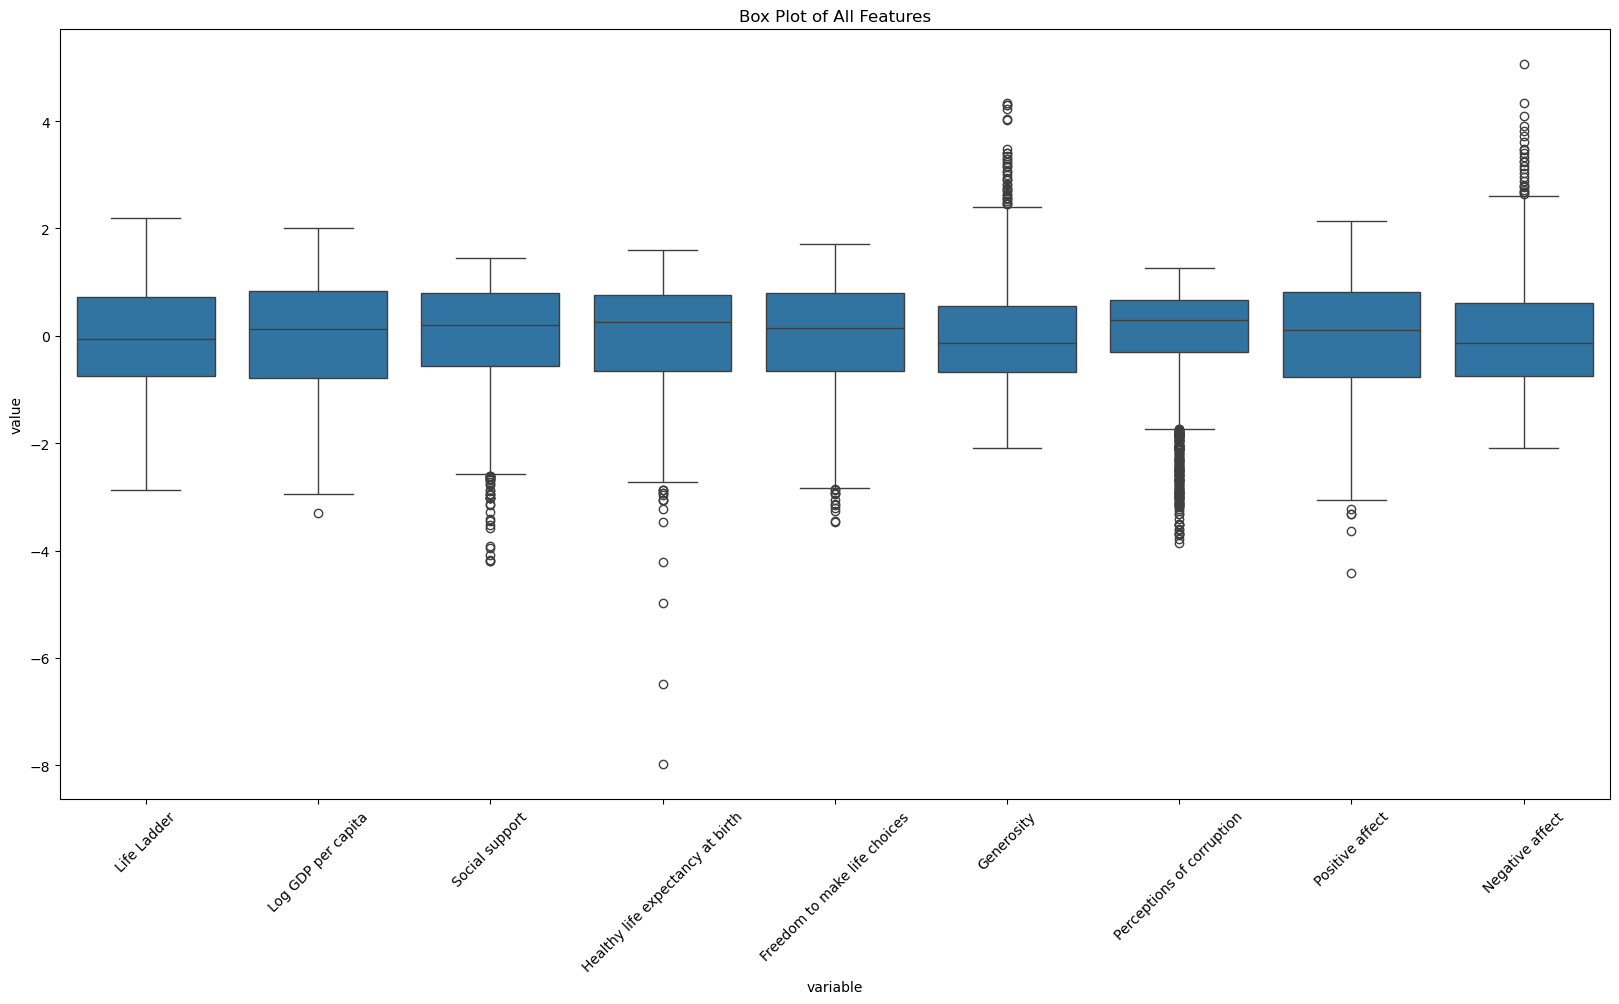

In [13]:
scaler = StandardScaler()

df_standardized = pd.DataFrame(scaler.fit_transform(df.drop(columns=["Country", "Year"])), columns=df.drop(columns=["Country", "Year"]).columns)

df_melted = df_standardized.melt()

plt.figure(figsize=(20, 10))
sns.boxplot(x='variable', y='value', data=df_melted)

plt.title("Box Plot of All Features")
plt.xticks(rotation=45) 
plt.show()

##### Histograms

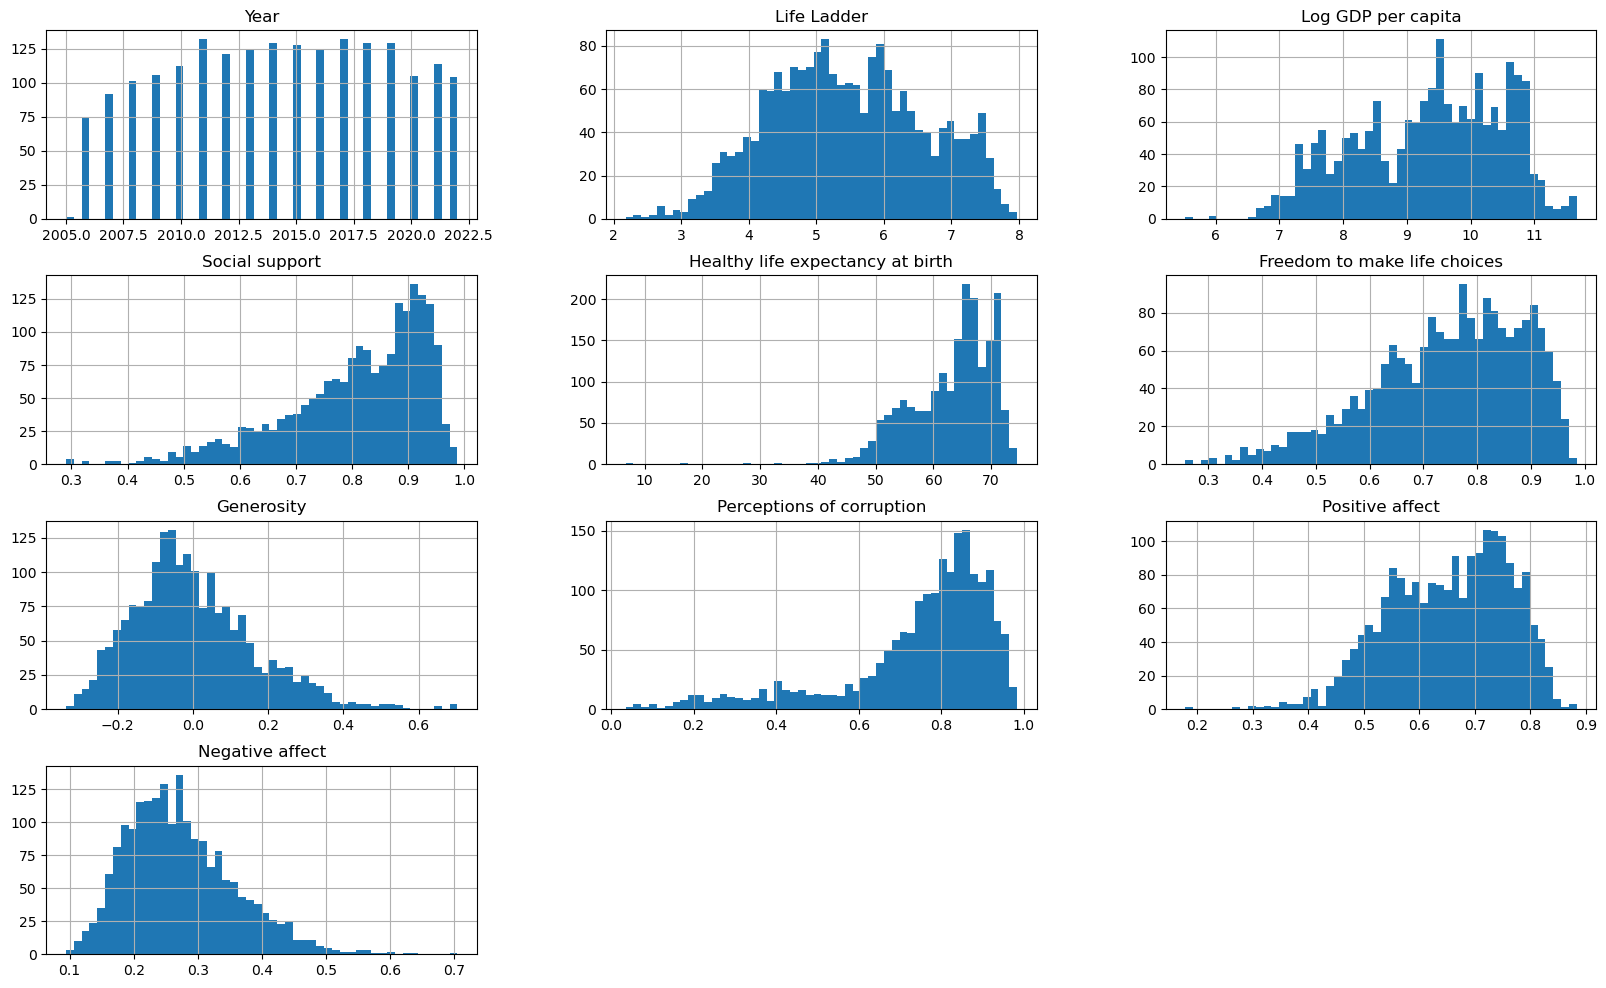

In [15]:
df.drop(columns="Country").hist(bins=50, figsize=(20, 12))

plt.show()

### 1.2) Calculating outliers

Outliers can severaly affect the K-Mean clustering. I'm therefore investigating the outliers of this data to assess whether I should include outliers

In [18]:
dict_of_out_info = calculate_outliers (df, False, True, True, 1.5, "Year")

No outliers calculated for the column arguments
Number of outliers in Life Ladder: 0
Number of outliers in Log GDP per capita: 1
Number of outliers in Social support: 34
Number of outliers in Healthy life expectancy at birth: 15
Number of outliers in Freedom to make life choices: 12
Number of outliers in Generosity: 37
Number of outliers in Perceptions of corruption: 175
Number of outliers in Positive affect: 5
Number of outliers in Negative affect: 25
Total number of rows deleted in returned data frame: 290
Total number of outliers (if there are more outliers than deleted rows it means that some rows contain outliers in more than one column): 304


In [19]:
no_out_df = dict_of_out_info["df_without_outliers"]
no_out_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1668 entries, 1 to 2198
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country                           1668 non-null   object 
 1   Year                              1668 non-null   int64  
 2   Life Ladder                       1668 non-null   float64
 3   Log GDP per capita                1668 non-null   float64
 4   Social support                    1668 non-null   float64
 5   Healthy life expectancy at birth  1668 non-null   float64
 6   Freedom to make life choices      1668 non-null   float64
 7   Generosity                        1668 non-null   float64
 8   Perceptions of corruption         1668 non-null   float64
 9   Positive affect                   1668 non-null   float64
 10  Negative affect                   1668 non-null   float64
 11  ID                                1668 non-null   int64  
dtypes: float64(

In [20]:

gdp_out_df = dict_of_out_info["Log GDP per capita"]["outliers"]
social_sup_out_df = dict_of_out_info["Social support"]["outliers"]
health_out_df = dict_of_out_info["Healthy life expectancy at birth"]["outliers"]
freedom_out_df = dict_of_out_info["Freedom to make life choices"]["outliers"]
generosity_out_df = dict_of_out_info["Generosity"]["outliers"]
corrupt_out_df = dict_of_out_info["Perceptions of corruption"]["outliers"]
positive_out_df = dict_of_out_info["Positive affect"]["outliers"]
negative_out_df = dict_of_out_info["Negative affect"]["outliers"]


In [21]:
gdp_out_df.iloc[0:30]

,Country,Year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,ID
2134,Venezuela,2019,5.080803,5.526723,0.887672,64.400002,0.625526,0.128371,0.83934,0.729553,0.35095,1905


In [22]:
social_sup_out_df.iloc[0:30]


,Country,Year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,ID
0,Afghanistan,2008,3.723590,7.350416,0.450662,50.500000,0.718114,0.167652,0.881686,0.414297,0.258195,1
5,Afghanistan,2013,3.572100,7.680333,0.483552,52.000000,0.577955,0.062666,0.823204,0.547417,0.273328,6
11,Afghanistan,2019,2.375092,7.640086,0.419973,53.900002,0.393656,-0.106016,0.923849,0.324108,0.502474,12
12,Afghanistan,2021,2.436034,7.324032,0.454175,54.549999,0.394306,-0.081011,0.946299,0.178886,0.606713,13
134,Bangladesh,2008,5.052279,8.046942,0.466553,60.160000,0.606012,-0.057123,0.801820,0.544638,0.231861,122
147,Bangladesh,2021,4.123319,8.684572,0.484740,64.550003,0.893013,0.091825,0.746207,0.503551,0.448261,134
148,Bangladesh,2022,3.407532,8.743257,0.403708,64.675003,0.864576,-0.054776,0.616872,0.393517,0.448060,135
181,Benin,2006,3.329802,7.843533,0.444781,51.959999,0.580069,-0.011397,0.789862,0.520846,0.309100,166
182,Benin,2008,3.667140,7.891244,0.382374,52.480000,0.709477,-0.004467,0.825246,0.573910,0.302546,167
183,Benin,2011,3.870280,7.876235,0.477494,53.259998,0.772919,-0.142097,0.849472,0.574439,0.218678,168


In [23]:
health_out_df.iloc[0:30]


,Country,Year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,ID
344,Central African Republic,2007,4.160130,6.945774,0.532297,41.480000,0.662871,0.082950,0.782131,0.566929,0.329995,323
345,Central African Republic,2010,3.567893,7.030766,0.483334,42.500000,0.689951,-0.032762,0.845377,0.477915,0.256705,324
346,Central African Republic,2011,3.677826,7.056533,0.387391,42.840000,0.780018,-0.012097,0.834499,0.501873,0.277180,325
610,Eswatini,2011,4.867091,8.902075,0.837150,42.500000,0.607157,-0.066723,0.917250,0.756366,0.251053,559
766,Haiti,2006,3.754156,7.972617,0.693801,6.720000,0.449475,0.358533,0.853506,0.583196,0.332141,710
767,Haiti,2008,3.846329,8.012043,0.679098,17.360001,0.464971,0.216526,0.811659,0.572523,0.255774,711
768,Haiti,2010,3.765999,7.983535,0.554031,28.000000,0.372941,0.170872,0.848007,0.495069,0.292557,712
769,Haiti,2011,4.844574,8.022003,0.567039,33.320000,0.412588,0.197880,0.681960,0.550258,0.244856,713
770,Haiti,2012,4.413475,8.011640,0.748663,38.639999,0.482486,0.246083,0.717166,0.556583,0.283806,714
1118,Lesotho,2011,4.897515,7.785040,0.824085,41.520000,0.618260,-0.089229,0.767676,0.754062,0.170010,1000


In [24]:

freedom_out_df.iloc[0:30]


,Country,Year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,ID
215,Bosnia and Herzegovina,2007,4.899807,9.190633,0.765604,67.000000,0.341566,0.008483,0.926125,0.570178,0.296466,200
216,Bosnia and Herzegovina,2009,4.963477,9.246142,0.735232,67.000000,0.257534,-0.024914,0.958740,0.506856,0.390204,201
218,Bosnia and Herzegovina,2011,4.994671,9.299641,0.725243,67.000000,0.333312,-0.035210,0.924784,0.551055,0.325735,203
288,Burundi,2008,3.563228,6.700229,0.290934,49.660000,0.260069,-0.018414,0.859814,0.415190,0.252771,271
349,Chad,2006,3.434801,7.369200,0.724308,47.080002,0.306132,0.025770,0.961074,0.571168,0.262727,328
350,Chad,2007,4.141327,7.367519,0.478951,47.459999,0.294612,-0.013500,0.873610,0.597517,0.245208,329
774,Haiti,2016,3.352300,8.056166,0.583742,54.900002,0.303540,0.247953,0.838523,0.532205,0.367341,718
884,Iraq,2012,4.659509,9.132593,0.730118,60.860001,0.314565,-0.015048,0.789191,0.410450,0.449059,811
1168,Madagascar,2008,4.640079,7.413261,0.775689,54.619999,0.332436,-0.099016,0.773067,0.582537,0.214525,1047
1488,Pakistan,2008,4.413919,8.309402,0.372908,53.980000,0.335224,0.095418,0.847683,0.532505,0.320658,1354


In [25]:
generosity_out_df.iloc[0:30]


,Country,Year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,ID
298,Cambodia,2011,4.161225,7.957363,0.715519,59.340000,0.927462,0.416752,0.775356,0.637013,0.307869,279
668,Gambia,2018,4.922099,7.607178,0.684800,56.700001,0.718729,0.443072,0.691070,0.758668,0.379208,615
669,Gambia,2019,5.163627,7.641713,0.693870,57.000000,0.676595,0.412655,0.798108,0.717893,0.400723,616
852,Indonesia,2010,5.457299,9.013429,0.816022,61.200001,0.699658,0.445357,0.954050,0.716958,0.217908,781
853,Indonesia,2011,5.172608,9.060741,0.824977,61.419998,0.878287,0.435677,0.962295,0.747677,0.273416,782
856,Indonesia,2014,5.597375,9.185947,0.904828,62.080002,0.719413,0.405318,0.970144,0.757047,0.241678,785
857,Indonesia,2015,5.042800,9.222451,0.809478,62.299999,0.779418,0.468550,0.945967,0.796219,0.274292,786
858,Indonesia,2016,5.136325,9.260966,0.791831,62.424999,0.829942,0.496852,0.889677,0.747754,0.341574,787
859,Indonesia,2017,5.098402,9.300357,0.795589,62.549999,0.865026,0.484792,0.900416,0.781278,0.319172,788
860,Indonesia,2018,5.340296,9.341144,0.809379,62.674999,0.879374,0.508754,0.867729,0.796031,0.295987,789


In [26]:
corrupt_out_df.iloc[0:30]


,Country,Year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,ID
79,Australia,2010,7.450047,10.713649,0.954520,70.199997,0.932059,0.313121,0.366127,0.761716,0.220073,75
80,Australia,2011,7.405616,10.723386,0.967029,70.279999,0.944586,0.365759,0.381772,0.724132,0.195324,76
81,Australia,2012,7.195586,10.744205,0.944599,70.360001,0.935146,0.270048,0.368252,0.728092,0.214397,77
84,Australia,2015,7.309061,10.769909,0.951862,70.599998,0.921871,0.328289,0.356554,0.749504,0.209637,80
85,Australia,2016,7.250080,10.781229,0.942334,70.675003,0.922316,0.234967,0.398545,0.735896,0.236086,81
86,Australia,2017,7.257038,10.787260,0.949958,70.750000,0.910550,0.313771,0.411347,0.728150,0.225361,82
87,Australia,2018,7.176993,10.800653,0.940137,70.824997,0.916028,0.142901,0.404647,0.705983,0.187456,83
329,Canada,2008,7.485604,10.733166,0.938707,70.680000,0.926315,0.257703,0.369588,0.802224,0.202175,308
330,Canada,2009,7.487824,10.692027,0.942845,70.739998,0.915058,0.242370,0.412622,0.793211,0.247633,309
331,Canada,2010,7.650346,10.711336,0.953765,70.800003,0.933949,0.226587,0.412660,0.791042,0.233113,310


In [27]:
positive_out_df.iloc[0:30]


,Country,Year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,ID
12,Afghanistan,2021,2.436034,7.324032,0.454175,54.549999,0.394306,-0.081011,0.946299,0.178886,0.606713,13
1114,Lebanon,2019,4.024220,9.751047,0.865969,66.000000,0.447001,-0.095516,0.890416,0.307577,0.494499,996
1116,Lebanon,2021,2.178809,9.470949,0.506775,66.150002,0.422697,-0.161281,0.905279,0.263487,0.569101,998
1117,Lebanon,2022,2.352428,9.428473,0.534528,66.224998,0.449575,-0.125514,0.882996,0.297508,0.429903,999
1995,Turkiye,2021,4.366640,10.356681,0.736195,68.750000,0.446528,-0.036791,0.810166,0.297092,0.470579,1796


In [28]:
negative_out_df.iloc[0:30]

,Country,Year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,ID
11,Afghanistan,2019,2.375092,7.640086,0.419973,53.900002,0.393656,-0.106016,0.923849,0.324108,0.502474,12
12,Afghanistan,2021,2.436034,7.324032,0.454175,54.549999,0.394306,-0.081011,0.946299,0.178886,0.606713,13
75,Armenia,2022,5.381943,9.667766,0.811169,67.925003,0.789599,-0.154325,0.704730,0.530931,0.549468,72
123,Bahrain,2011,4.823976,10.748598,0.907868,65.239998,0.869870,-0.059403,0.582522,0.505992,0.513719,119
348,Central African Republic,2017,3.475862,6.732925,0.319589,45.299999,0.645252,0.077883,0.889566,0.602205,0.599335,327
360,Chad,2017,4.558937,7.365028,0.660616,51.250000,0.614850,0.006798,0.792390,0.584315,0.538245,339
361,Chad,2018,4.486325,7.354710,0.577254,51.625000,0.650355,0.023422,0.762879,0.532490,0.543836,340
363,Chad,2022,4.396646,7.261129,0.719672,53.125000,0.679480,0.221162,0.805424,0.588192,0.499192,342
870,Iran,2013,5.139579,9.554884,0.663707,65.419998,0.730215,0.204346,0.685038,0.574902,0.551840,797
871,Iran,2014,4.682224,9.584558,0.644064,65.559998,0.766823,0.229623,0.639682,0.549892,0.511569,798


#### 1.2.1) Outlier assessment

I find it difficult to assess whether outliers should be included in clustering. All outliers seems valid and they can potentially provide valuable information of the relation between happiness and GDP 

# 2) Preparation of data for clustering

### 2.1) Standardization of data

I'm standardizing the data so that each feature contributes equally to the distance measurements in my K-Mean clustering

In [34]:
# I have already standardized the data when I calculated and showed the box plots of the data

df_standardized.head()

,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,-1.521017,-1.722068,-2.895393,-1.790918,-0.194681,1.035838,0.722945,-2.226770,-0.177218
1,-0.926496,-1.585391,-2.072060,-1.748467,-0.473854,1.179097,0.551871,-1.602175,-0.424651
2,-0.613888,-1.494474,-2.179249,-1.706016,-1.034573,0.749173,-0.222502,-1.271983,0.023610
3,-1.426228,-1.522669,-2.324819,-1.663564,-1.776506,1.010591,-0.090930,-1.616940,-0.071938
4,-1.468991,-1.454216,-2.328601,-1.621112,-1.527119,1.468499,0.149654,-0.373059,-0.063209


# 3) K-Mean clustering of data

### 3.1) Estimating the best fitting number of clusters

In [37]:
features_for_clustering = df_standardized[["Log GDP per capita", "Social support", "Healthy life expectancy at birth", "Freedom to make life choices","Generosity", "Perceptions of corruption", "Positive affect", "Negative affect"]]

##### Inertia

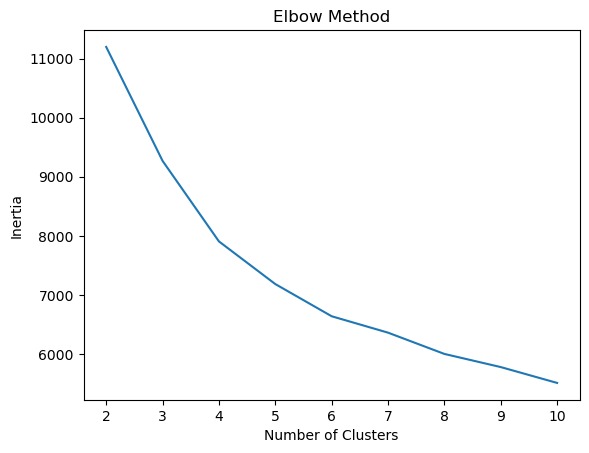

In [39]:
inertia = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_for_clustering)
    inertia.append(kmeans.inertia_)

plt.plot(range(2, 11), inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

##### Distortions

In [41]:
distortions = []

K = range(2,10)
for k in K:
    model = KMeans(n_clusters=k, n_init=10).fit(features_for_clustering)
    model.fit(features_for_clustering)
    distortions.append(sum(np.min(cdist(features_for_clustering, model.cluster_centers_, 'euclidean'), axis=1)) / features_for_clustering.shape[0]) 


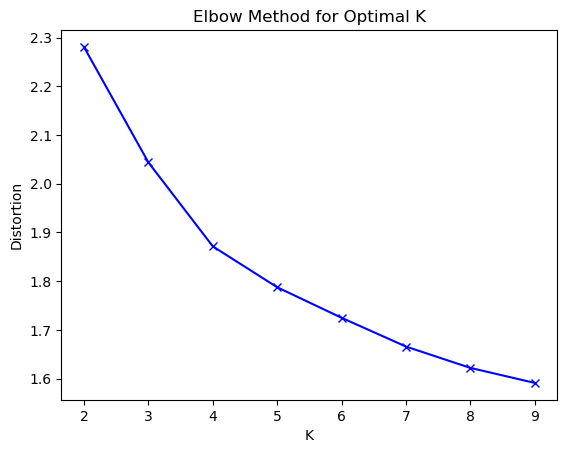

In [42]:
plt.title('Elbow Method for Optimal K')
plt.plot(K, distortions, 'bx-')
plt.xlabel('K')
plt.ylabel('Distortion')
plt.show()

##### Silhoutte score

In [44]:
scores = []
K = range(2,10)
for k in K:
    model1 = KMeans(n_clusters=k, n_init=10)
    model1.fit(features_for_clustering)
    score1 = metrics.silhouette_score(features_for_clustering, model1.labels_, metric='euclidean', sample_size=len(features_for_clustering))
    print("\nNumber of clusters =", k)
    print("Silhouette score =", score1)
    scores.append(score1)


Number of clusters = 2
Silhouette score = 0.2508893293009439

Number of clusters = 3
Silhouette score = 0.23810111309615956

Number of clusters = 4
Silhouette score = 0.23792742670576605

Number of clusters = 5
Silhouette score = 0.2343128744303272

Number of clusters = 6
Silhouette score = 0.229330483978921

Number of clusters = 7
Silhouette score = 0.21363933358675793

Number of clusters = 8
Silhouette score = 0.2042693001762955

Number of clusters = 9
Silhouette score = 0.2049298096434239


### 3.2) Training the K-Means model and assigning each row to a cluster

In [72]:
num_clusters = 3

kmeans = KMeans(n_clusters=num_clusters, random_state=42)

df_standardized['Cluster'] = kmeans.fit_predict(features_for_clustering)

df_standardized['Country'] = df['Country'].values
df_standardized['Year'] = df['Year'].values

df_standardized = df_standardized[['Country', 'Year'] + list(df_standardized.columns[:-2])]

df_standardized.head()

,Country,Year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,Cluster
0,Afghanistan,2008,-1.521017,-1.722068,-2.895393,-1.790918,-0.194681,1.035838,0.722945,-2.226770,-0.177218,0
1,Afghanistan,2009,-0.926496,-1.585391,-2.072060,-1.748467,-0.473854,1.179097,0.551871,-1.602175,-0.424651,0
2,Afghanistan,2010,-0.613888,-1.494474,-2.179249,-1.706016,-1.034573,0.749173,-0.222502,-1.271983,0.023610,0
3,Afghanistan,2011,-1.426228,-1.522669,-2.324819,-1.663564,-1.776506,1.010591,-0.090930,-1.616940,-0.071938,0
4,Afghanistan,2012,-1.468991,-1.454216,-2.328601,-1.621112,-1.527119,1.468499,0.149654,-0.373059,-0.063209,0


In [83]:
cluster1_df = df_standardized[df_standardized["Cluster"]==0]
cluster2_df = df_standardized[df_standardized["Cluster"]==1]
cluster3_df = df_standardized[df_standardized["Cluster"]==2]

In [85]:
cluster1_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 675 entries, 0 to 1957
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country                           675 non-null    object 
 1   Year                              675 non-null    int64  
 2   Life Ladder                       675 non-null    float64
 3   Log GDP per capita                675 non-null    float64
 4   Social support                    675 non-null    float64
 5   Healthy life expectancy at birth  675 non-null    float64
 6   Freedom to make life choices      675 non-null    float64
 7   Generosity                        675 non-null    float64
 8   Perceptions of corruption         675 non-null    float64
 9   Positive affect                   675 non-null    float64
 10  Negative affect                   675 non-null    float64
 11  Cluster                           675 non-null    int32  
dtypes: float64(9

In [96]:
countries1 = cluster1_df["Country"].nunique()
print(countries1)

76


In [104]:
countries1_vc = cluster1_df["Country"].value_counts()
print(countries1_vc)

Country
Zimbabwe        17
Cameroon        17
Kenya           17
Ghana           17
Tanzania        16
                ..
Croatia          1
Jordan           1
South Africa     1
Namibia          1
Romania          1
Name: count, Length: 76, dtype: int64


In [87]:
cluster2_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 961 entries, 13 to 1916
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country                           961 non-null    object 
 1   Year                              961 non-null    int64  
 2   Life Ladder                       961 non-null    float64
 3   Log GDP per capita                961 non-null    float64
 4   Social support                    961 non-null    float64
 5   Healthy life expectancy at birth  961 non-null    float64
 6   Freedom to make life choices      961 non-null    float64
 7   Generosity                        961 non-null    float64
 8   Perceptions of corruption         961 non-null    float64
 9   Positive affect                   961 non-null    float64
 10  Negative affect                   961 non-null    float64
 11  Cluster                           961 non-null    int32  
dtypes: float64(

In [98]:
countries2 = cluster2_df["Country"].nunique()
print(countries2)

93


In [122]:
countries2_vc = cluster2_df["Country"].value_counts()

print(countries2_vc)

Country
El Salvador           17
Bolivia               17
Russia                17
Ecuador               17
Dominican Republic    17
                      ..
Sudan                  1
Germany                1
Uzbekistan             1
Kuwait                 1
Bhutan                 1
Name: count, Length: 93, dtype: int64


In [89]:
cluster3_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 322 entries, 72 to 1891
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country                           322 non-null    object 
 1   Year                              322 non-null    int64  
 2   Life Ladder                       322 non-null    float64
 3   Log GDP per capita                322 non-null    float64
 4   Social support                    322 non-null    float64
 5   Healthy life expectancy at birth  322 non-null    float64
 6   Freedom to make life choices      322 non-null    float64
 7   Generosity                        322 non-null    float64
 8   Perceptions of corruption         322 non-null    float64
 9   Positive affect                   322 non-null    float64
 10  Negative affect                   322 non-null    float64
 11  Cluster                           322 non-null    int32  
dtypes: float64(

In [100]:
countries3 = cluster3_df["Country"].nunique()
print(countries3)

35


In [108]:
countries3_vc = cluster3_df["Country"].value_counts()
print(countries3_vc)

Country
Sweden                  16
United Kingdom          16
New Zealand             16
Canada                  16
Denmark                 16
Ireland                 16
Australia               15
Netherlands             15
Finland                 15
Austria                 15
Germany                 14
Singapore               13
Thailand                13
United States           13
Norway                  12
Switzerland             12
Luxembourg              12
Uzbekistan              11
Belgium                  9
Iceland                  9
Myanmar                  8
Malta                    6
Indonesia                5
Estonia                  4
Laos                     4
Uruguay                  3
United Arab Emirates     3
Sri Lanka                3
Rwanda                   3
Bhutan                   2
Kuwait                   2
Malaysia                 2
France                   1
Qatar                    1
Bahrain                  1
Name: count, dtype: int64


### 3.3) Deleting rows before Linear Regression models

I'm deleting all the countries from the 3 cluster data frames which appear less than 8 times in the given cluster data frame. This is because I want to have the countries separated so a country only appear in 1 cluster and so that the cluster the country appears in is the cluster with the most appearences of the country.   

In [125]:
filtered_countries1_vc = countries1_vc[countries1_vc < 8]
filtered_countries2_vc = countries2_vc[countries2_vc < 8]
filtered_countries3_vc = countries3_vc[countries3_vc < 8]

In [127]:
filtered_countries1_vc.info()

<class 'pandas.core.series.Series'>
Index: 30 entries, Comoros to Romania
Series name: count
Non-Null Count  Dtype
--------------  -----
30 non-null     int64
dtypes: int64(1)
memory usage: 480.0+ bytes


In [129]:
filtered_countries2_vc.info()

<class 'pandas.core.series.Series'>
Index: 33 entries, Lebanon to Bhutan
Series name: count
Non-Null Count  Dtype
--------------  -----
33 non-null     int64
dtypes: int64(1)
memory usage: 528.0+ bytes


In [131]:
filtered_countries3_vc.info()

<class 'pandas.core.series.Series'>
Index: 14 entries, Malta to Bahrain
Series name: count
Non-Null Count  Dtype
--------------  -----
14 non-null     int64
dtypes: int64(1)
memory usage: 224.0+ bytes


In [135]:
countries_to_remove1 = filtered_countries1_vc.index
countries_to_remove2 = filtered_countries2_vc.index
countries_to_remove3 = filtered_countries3_vc.index

filtered_df1 = cluster1_df[~cluster1_df['Country'].isin(countries_to_remove1)]
filtered_df2 = cluster2_df[~cluster2_df['Country'].isin(countries_to_remove2)]
filtered_df3 = cluster3_df[~cluster3_df['Country'].isin(countries_to_remove3)]

In [137]:
filtered_df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 581 entries, 0 to 1957
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country                           581 non-null    object 
 1   Year                              581 non-null    int64  
 2   Life Ladder                       581 non-null    float64
 3   Log GDP per capita                581 non-null    float64
 4   Social support                    581 non-null    float64
 5   Healthy life expectancy at birth  581 non-null    float64
 6   Freedom to make life choices      581 non-null    float64
 7   Generosity                        581 non-null    float64
 8   Perceptions of corruption         581 non-null    float64
 9   Positive affect                   581 non-null    float64
 10  Negative affect                   581 non-null    float64
 11  Cluster                           581 non-null    int32  
dtypes: float64(9

In [139]:
filtered_df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 862 entries, 13 to 1916
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country                           862 non-null    object 
 1   Year                              862 non-null    int64  
 2   Life Ladder                       862 non-null    float64
 3   Log GDP per capita                862 non-null    float64
 4   Social support                    862 non-null    float64
 5   Healthy life expectancy at birth  862 non-null    float64
 6   Freedom to make life choices      862 non-null    float64
 7   Generosity                        862 non-null    float64
 8   Perceptions of corruption         862 non-null    float64
 9   Positive affect                   862 non-null    float64
 10  Negative affect                   862 non-null    float64
 11  Cluster                           862 non-null    int32  
dtypes: float64(

In [141]:
filtered_df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 282 entries, 72 to 1891
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country                           282 non-null    object 
 1   Year                              282 non-null    int64  
 2   Life Ladder                       282 non-null    float64
 3   Log GDP per capita                282 non-null    float64
 4   Social support                    282 non-null    float64
 5   Healthy life expectancy at birth  282 non-null    float64
 6   Freedom to make life choices      282 non-null    float64
 7   Generosity                        282 non-null    float64
 8   Perceptions of corruption         282 non-null    float64
 9   Positive affect                   282 non-null    float64
 10  Negative affect                   282 non-null    float64
 11  Cluster                           282 non-null    int32  
dtypes: float64(

#### 3.3.1) Checking that every country only appear in 1 filtered cluster df

In [162]:
df1_countries = set(filtered_df1['Country'].unique())
df2_countries = set(filtered_df2['Country'].unique())
df3_countries = set(filtered_df3['Country'].unique())

if df1_countries.isdisjoint(df2_countries) and df1_countries.isdisjoint(df3_countries) and df2_countries.isdisjoint(df3_countries):
    print("All the values in the 'Country' column are different across the DataFrames.")
else:
    print("There are common values in the 'Country' column between the DataFrames.")


All the values in the 'Country' column are different across the DataFrames.


### 3.4) Validating the model with silhoutte score (proforma: Already checked it earlier when choosing number of clusters)

In [230]:
score2 = metrics.silhouette_score(features_for_clustering, kmeans.labels_, metric='euclidean')
print('Silhouette Score: %.3f' % score2)

Silhouette Score: 0.238


# 4) Multiple Linear Regression models for predicting GDP

### 4.1) Training and testing models

##### X features

In [185]:
X = ["Social support", "Life Ladder","Healthy life expectancy at birth","Freedom to make life choices", "Generosity","Perceptions of corruption", "Positive affect", "Negative affect"]

##### Original data (not clustered)

In [188]:
linear_model_org = train_and_test_linear_model(df_standardized, "Log GDP per capita", X, .2, False)

               Metric  Value
0                 MAE  0.310
1                 MSE  0.182
2                RMSE  0.427
3  Explained Variance  0.792
4           R-Squared  0.791


##### Cluster 1

In [191]:
linear_clust1 = train_and_test_linear_model(filtered_df1, "Log GDP per capita", X, .2, False)

               Metric  Value
0                 MAE  0.368
1                 MSE  0.206
2                RMSE  0.454
3  Explained Variance  0.520
4           R-Squared  0.513


##### Cluster 2

In [194]:
linear_clust2 = train_and_test_linear_model(filtered_df2, "Log GDP per capita", X, .2, False)

               Metric  Value
0                 MAE  0.264
1                 MSE  0.116
2                RMSE  0.340
3  Explained Variance  0.560
4           R-Squared  0.558


##### Cluster 3

In [197]:
linear_clust3 = train_and_test_linear_model(filtered_df3, "Log GDP per capita", X, .2, False)

               Metric  Value
0                 MAE  0.188
1                 MSE  0.057
2                RMSE  0.239
3  Explained Variance  0.774
4           R-Squared  0.767


### 4.2) Evaluating models

2 of the 3 clusters (cluster 1 and 2) are not that great at predicting the GDP from the happiness features (they both have an R-Squared under 0.6). On the other hand cluster 3 does predict GDP from happiness features quite well with an R-Squared of 0.767.



# 5) Polynomial regression models

In [224]:
poly_model_org = train_and_test_linear_model(df_standardized, "Log GDP per capita", X, .2, True, 2)


               Metric  Value
0                 MAE  0.255
1                 MSE  0.104
2                RMSE  0.323
3  Explained Variance  0.881
4           R-Squared  0.881


In [220]:
poly_clust1 = train_and_test_linear_model(filtered_df1, "Log GDP per capita", X, .2, True, 2)


               Metric  Value
0                 MAE  0.278
1                 MSE  0.133
2                RMSE  0.364
3  Explained Variance  0.689
4           R-Squared  0.687


In [222]:
poly_clust2 = train_and_test_linear_model(filtered_df2, "Log GDP per capita", X, .2, True,3)


               Metric  Value
0                 MAE  0.187
1                 MSE  0.065
2                RMSE  0.254
3  Explained Variance  0.754
4           R-Squared  0.753


In [216]:
poly_clust3 = train_and_test_linear_model(filtered_df3, "Log GDP per capita", X, .2, True, 2)

               Metric  Value
0                 MAE  0.154
1                 MSE  0.039
2                RMSE  0.197
3  Explained Variance  0.842
4           R-Squared  0.842


In [226]:
filtered_df3["Country"].value_counts()

Country
Ireland           16
Sweden            16
Canada            16
Denmark           16
New Zealand       16
United Kingdom    16
Austria           15
Netherlands       15
Australia         15
Finland           15
Germany           14
Thailand          13
Singapore         13
United States     13
Luxembourg        12
Norway            12
Switzerland       12
Uzbekistan        11
Iceland            9
Belgium            9
Myanmar            8
Name: count, dtype: int64